# **Using PCA and various ML algorithms to classify genes linked with certain diseases.**

In [1]:
# Import the required modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import labels

y = pd.read_csv('/content/actual.csv')
print(y.shape)
y.head()

(72, 2)


,patient,cancer
0,1,ALL
1,2,ALL
2,3,ALL
3,4,ALL
4,5,ALL


**NOTE**: The lables have patients in a column

In [3]:
# Counting patients with Acute Myeloid Leukemia (AML) or Acute Lymphocytic Leukemia (ALL)

y['cancer'].value_counts()

ALL    47
AML    25
Name: cancer, dtype: int64

In [4]:
# Encoding the labels

labels = ['ALL', 'AML']
y = y.replace({'ALL':0,'AML':1})
y.head()

,patient,cancer
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [5]:
# Load the training dataset

df_train= pd.read_csv('/content/data_set_ALL_AML_train.csv')
print(df_train.shape)
df_train.head()

(7129, 78)


,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,...,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,...,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,...,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,...,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,...,-51,A,-139,A,-367,A,-188,A,-407,A


In [6]:
# Load the testing dataset

df_test= pd.read_csv('/content/data_set_ALL_AML_independent.csv')
print(df_test.shape)
df_test.head()

(7129, 70)


,Gene Description,Gene Accession Number,39,call,40,call.1,42,call.2,47,call.3,...,65,call.29,66,call.30,63,call.31,64,call.32,62,call.33
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-342,A,-87,A,22,A,-243,A,...,-62,A,-58,A,-161,A,-48,A,-176,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-200,A,-248,A,-153,A,-218,A,...,-198,A,-217,A,-215,A,-531,A,-284,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,41,A,262,A,17,A,-163,A,...,-5,A,63,A,-46,A,-124,A,-81,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,328,A,295,A,276,A,182,A,...,141,A,95,A,146,A,431,A,9,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-224,A,-226,A,-211,A,-289,A,...,-256,A,-191,A,-172,A,-496,A,-294,A


In [7]:
# Cleaning the datasets

df1 = [col for col in df_train.columns if "call" not in col]
df_train = df_train[df1]
df2 = [col for col in df_test.columns if "call" not in col]
df_test = df_test[df2]

In [8]:
# Examining the new datasets

print(df_train.shape)
display(df_train.head())
print(df_test.shape)
display(df_test.head())

(7129, 40)


,Gene Description,Gene Accession Number,1,2,3,4,5,6,7,8,...,35,36,37,38,28,29,30,31,32,33
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,-139,-76,-135,-106,-138,-72,-413,...,7,-213,-25,-72,-4,15,-318,-32,-124,-135
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,-73,-49,-114,-125,-85,-144,-260,...,-100,-252,-20,-139,-116,-114,-192,-49,-79,-186
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,-1,-307,265,-76,215,238,7,...,-57,136,124,-1,-125,2,-95,49,-37,-70
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,283,309,12,168,71,55,-2,...,132,318,325,392,241,193,312,230,330,337
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,-264,-376,-419,-230,-272,-399,-541,...,-377,-209,-396,-324,-191,-51,-139,-367,-188,-407


(7129, 36)


,Gene Description,Gene Accession Number,39,40,42,47,48,49,41,43,...,54,57,58,60,61,65,66,63,64,62
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-342,-87,22,-243,-130,-256,-62,86,...,-90,-137,-157,-172,-47,-62,-58,-161,-48,-176
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-200,-248,-153,-218,-177,-249,-23,-36,...,-87,-51,-370,-122,-442,-198,-217,-215,-531,-284
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,41,262,17,-163,-28,-410,-7,-141,...,102,-82,-77,38,-21,-5,63,-46,-124,-81
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,328,295,276,182,266,24,142,252,...,319,178,340,31,396,141,95,146,431,9
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-224,-226,-211,-289,-170,-535,-233,-201,...,-283,-135,-438,-201,-351,-256,-191,-172,-496,-294


**NOTE**: The datasets have patient details in a row. We will need to take a transpose at some point to align them.

In [9]:
# Sorting the training data columns so that the labels line up.

train_columns_titles = ['Gene Description', 'Gene Accession Number', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
       '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38']

x_train = df_train.reindex(columns=train_columns_titles)
x_train

,Gene Description,Gene Accession Number,1,2,3,4,5,6,7,8,...,29,30,31,32,33,34,35,36,37,38
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,-139,-76,-135,-106,-138,-72,-413,...,15,-318,-32,-124,-135,-20,7,-213,-25,-72
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,-73,-49,-114,-125,-85,-144,-260,...,-114,-192,-49,-79,-186,-207,-100,-252,-20,-139
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,-1,-307,265,-76,215,238,7,...,2,-95,49,-37,-70,-50,-57,136,124,-1
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,283,309,12,168,71,55,-2,...,193,312,230,330,337,101,132,318,325,392
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,-264,-376,-419,-230,-272,-399,-541,...,-51,-139,-367,-188,-407,-369,-377,-209,-396,-324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7124,PTGER3 Prostaglandin E receptor 3 (subtype EP3...,X83863_at,793,782,1138,627,250,645,1140,1799,...,279,737,588,1170,2315,834,752,1293,1733,1567
7125,HMG2 High-mobility group (nonhistone chromosom...,Z17240_at,329,295,777,170,314,341,482,446,...,51,227,361,284,250,557,295,342,304,627
7126,RB1 Retinoblastoma 1 (including osteosarcoma),L49218_f_at,36,11,41,-50,14,26,10,59,...,6,-9,-26,39,-12,-12,28,26,12,21
7127,GB DEF = Glycophorin Sta (type A) exons 3 and ...,M71243_f_at,191,76,228,126,56,193,369,781,...,2484,371,133,298,790,335,1558,246,3193,2520


In [10]:
# Sorting the testing data columns so that the labels line up.

test_columns_titles = ['Gene Description', 'Gene Accession Number','39', '40', '41', '42', '43', '44', '45', '46',
       '47', '48', '49', '50', '51', '52', '53',  '54', '55', '56', '57', '58', '59',
       '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72']

x_test = df_test.reindex(columns=test_columns_titles)
x_test

,Gene Description,Gene Accession Number,39,40,41,42,43,44,45,46,...,63,64,65,66,67,68,69,70,71,72
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-342,-87,-62,22,86,-146,-187,-56,...,-161,-48,-62,-58,-76,-154,-79,-55,-59,-131
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-200,-248,-23,-153,-36,-74,-187,-43,...,-215,-531,-198,-217,-98,-136,-118,-44,-114,-126
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,41,262,-7,17,-141,170,312,43,...,-46,-124,-5,63,-153,49,-30,12,23,-50
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,328,295,142,276,252,174,142,177,...,146,431,141,95,237,180,68,129,146,211
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-224,-226,-233,-211,-201,-32,114,-116,...,-172,-496,-256,-191,-215,-257,-110,-108,-171,-206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7124,PTGER3 Prostaglandin E receptor 3 (subtype EP3...,X83863_at,1074,67,245,893,1235,354,304,625,...,809,466,707,423,441,524,742,320,348,874
7125,HMG2 High-mobility group (nonhistone chromosom...,Z17240_at,475,263,164,297,9,-42,-1,173,...,445,349,354,41,99,249,234,174,208,393
7126,RB1 Retinoblastoma 1 (including osteosarcoma),L49218_f_at,48,-33,84,6,7,-100,-207,63,...,-2,0,-22,0,-8,40,72,-4,0,34
7127,GB DEF = Glycophorin Sta (type A) exons 3 and ...,M71243_f_at,168,-33,100,1971,1545,45,112,63,...,210,284,260,1777,80,-68,109,176,74,237


In [11]:
# Transposing the training and testing data

x_train = x_train.T
x_test = x_test.T
print(x_train.shape)
display(x_train.head())
print(x_test.shape)
display(x_test.head())

(40, 7129)


,0,1,2,3,4,5,6,7,8,9,...,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
Gene Description,AFFX-BioB-5_at (endogenous control),AFFX-BioB-M_at (endogenous control),AFFX-BioB-3_at (endogenous control),AFFX-BioC-5_at (endogenous control),AFFX-BioC-3_at (endogenous control),AFFX-BioDn-5_at (endogenous control),AFFX-BioDn-3_at (endogenous control),AFFX-CreX-5_at (endogenous control),AFFX-CreX-3_at (endogenous control),AFFX-BioB-5_st (endogenous control),...,Transcription factor Stat5b (stat5b) mRNA,Breast epithelial antigen BA46 mRNA,GB DEF = Calcium/calmodulin-dependent protein ...,TUBULIN ALPHA-4 CHAIN,CYP4B1 Cytochrome P450; subfamily IVB; polypep...,PTGER3 Prostaglandin E receptor 3 (subtype EP3...,HMG2 High-mobility group (nonhistone chromosom...,RB1 Retinoblastoma 1 (including osteosarcoma),GB DEF = Glycophorin Sta (type A) exons 3 and ...,GB DEF = mRNA (clone 1A7)
Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41


(36, 7129)


,0,1,2,3,4,5,6,7,8,9,...,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
Gene Description,AFFX-BioB-5_at (endogenous control),AFFX-BioB-M_at (endogenous control),AFFX-BioB-3_at (endogenous control),AFFX-BioC-5_at (endogenous control),AFFX-BioC-3_at (endogenous control),AFFX-BioDn-5_at (endogenous control),AFFX-BioDn-3_at (endogenous control),AFFX-CreX-5_at (endogenous control),AFFX-CreX-3_at (endogenous control),AFFX-BioB-5_st (endogenous control),...,Transcription factor Stat5b (stat5b) mRNA,Breast epithelial antigen BA46 mRNA,GB DEF = Calcium/calmodulin-dependent protein ...,TUBULIN ALPHA-4 CHAIN,CYP4B1 Cytochrome P450; subfamily IVB; polypep...,PTGER3 Prostaglandin E receptor 3 (subtype EP3...,HMG2 High-mobility group (nonhistone chromosom...,RB1 Retinoblastoma 1 (including osteosarcoma),GB DEF = Glycophorin Sta (type A) exons 3 and ...,GB DEF = mRNA (clone 1A7)
Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
39,-342,-200,41,328,-224,-427,-656,-292,137,-144,...,277,1023,67,214,-135,1074,475,48,168,-70
40,-87,-248,262,295,-226,-493,367,-452,194,162,...,83,529,-295,352,-67,67,263,-33,-33,-21
41,-62,-23,-7,142,-233,-284,-167,-97,-12,-70,...,129,383,46,104,15,245,164,84,100,-18


**NOTE**: As we can see, the Gene Description and the Gene Accession Number rows are similar. Hence, we're going to clean the rows by turning the second row into the column names and deleting the first row.

In [12]:
# Cleaning the column names for training and testing data

x_train.columns = x_train.iloc[1]
x_train = x_train.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)
x_test.columns = x_test.iloc[1]
x_test = x_test.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)

In [13]:
# To join Labels with the training/testing datasets, we need to reset the index as the indexes of two dataframes need to be the same before we combine them.

x_train = x_train.reset_index(drop=True)
y_train = y[y.patient <= 38].reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_test = y[y.patient > 38].reset_index(drop=True)

In [14]:
# Checking the clean datasets

print(x_train.shape)
display(x_train.head())
print(x_test.shape)
display(x_test.head())

(38, 7129)


Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
1,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
2,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41
3,-135,-114,265,12,-419,-585,158,-253,49,31,...,240,835,218,174,-110,627,170,-50,126,-91
4,-106,-125,-76,168,-230,-284,4,-122,70,252,...,156,649,57,504,-26,250,314,14,56,-25


(34, 7129)


Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,-342,-200,41,328,-224,-427,-656,-292,137,-144,...,277,1023,67,214,-135,1074,475,48,168,-70
1,-87,-248,262,295,-226,-493,367,-452,194,162,...,83,529,-295,352,-67,67,263,-33,-33,-21
2,-62,-23,-7,142,-233,-284,-167,-97,-12,-70,...,129,383,46,104,15,245,164,84,100,-18
3,22,-153,17,276,-211,-250,55,-141,0,500,...,413,399,16,558,24,893,297,6,1971,-42
4,86,-36,-141,252,-201,-384,-420,-197,-60,-468,...,341,91,-84,615,-52,1235,9,7,1545,-81


In [15]:
# Analyzing the mean, SD and other stats of the datasets

display(x_train.describe())
display(x_test.describe())
display(y.describe())

Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,...,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000
mean,-120.868421,-150.526316,-17.157895,181.394737,-276.552632,-439.210526,-43.578947,-201.184211,99.052632,112.131579,...,178.763158,750.842105,8.815789,399.131579,-20.052632,869.052632,335.842105,19.210526,504.394737,-29.210526
std,109.555656,75.734507,117.686144,117.468004,111.004431,135.458412,219.482393,90.838989,83.178397,211.815597,...,84.826830,298.008392,77.108507,469.579868,42.346031,482.366461,209.826766,31.158841,728.744405,30.851132
min,-476.000000,-327.000000,-307.000000,-36.000000,-541.000000,-790.000000,-479.000000,-463.000000,-82.000000,-215.000000,...,30.000000,224.000000,-178.000000,36.000000,-112.000000,195.000000,41.000000,-50.000000,-2.000000,-94.000000
25%,-138.750000,-205.000000,-83.250000,81.250000,-374.250000,-547.000000,-169.000000,-239.250000,36.000000,-47.000000,...,120.000000,575.500000,-42.750000,174.500000,-48.000000,595.250000,232.750000,8.000000,136.000000,-42.750000
50%,-106.500000,-141.500000,-43.500000,200.000000,-263.000000,-426.500000,-33.500000,-185.500000,99.500000,70.500000,...,174.500000,700.000000,10.500000,266.000000,-18.000000,744.500000,308.500000,20.000000,243.500000,-26.000000
75%,-68.250000,-94.750000,47.250000,279.250000,-188.750000,-344.750000,79.000000,-144.750000,152.250000,242.750000,...,231.750000,969.500000,57.000000,451.750000,9.250000,1112.000000,389.500000,30.250000,487.250000,-11.500000
max,17.000000,-20.000000,265.000000,392.000000,-51.000000,-155.000000,419.000000,-24.000000,283.000000,561.000000,...,356.000000,1653.000000,218.000000,2527.000000,52.000000,2315.000000,1109.000000,115.000000,3193.000000,36.000000


Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,...,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,-107.558824,-170.852941,2.088235,198.235294,-227.323529,-347.970588,-88.470588,-178.970588,58.882353,82.617647,...,171.529412,576.205882,-34.735294,362.441176,-48.882353,681.647059,268.294118,-1.205882,354.235294,-32.088235
std,83.662088,115.018347,129.075117,106.335392,130.331215,153.288891,345.372108,109.298447,92.545080,245.681121,...,104.732049,291.440599,93.479315,245.543947,58.024950,397.651887,199.751289,54.930689,479.403990,49.030212
min,-342.000000,-531.000000,-410.000000,9.000000,-535.000000,-810.000000,-1038.000000,-452.000000,-148.000000,-468.000000,...,-58.000000,91.000000,-295.000000,-24.000000,-220.000000,67.000000,-42.000000,-207.000000,-68.000000,-190.000000
25%,-156.250000,-216.500000,-49.000000,142.000000,-276.500000,-398.500000,-222.000000,-224.750000,-6.000000,-95.500000,...,94.750000,387.000000,-78.250000,239.250000,-78.000000,427.500000,165.500000,-19.250000,102.250000,-63.500000
50%,-92.500000,-148.500000,10.000000,177.500000,-208.500000,-309.500000,-95.500000,-141.000000,46.000000,102.000000,...,151.500000,557.000000,-9.500000,298.500000,-52.500000,621.500000,241.500000,0.000000,203.000000,-31.500000
75%,-56.500000,-102.000000,47.500000,274.500000,-170.250000,-246.250000,119.500000,-106.500000,130.000000,197.000000,...,212.000000,695.250000,31.000000,459.000000,2.000000,880.000000,366.000000,26.750000,328.500000,-1.250000
max,86.000000,-13.000000,312.000000,431.000000,114.000000,-122.000000,709.000000,-11.000000,236.000000,878.000000,...,413.000000,1455.000000,132.000000,1075.000000,47.000000,1950.000000,906.000000,84.000000,1971.000000,78.000000


,patient,cancer
count,72.00000,72.000000
mean,36.50000,0.347222
std,20.92845,0.479428
min,1.00000,0.000000
25%,18.75000,0.000000
50%,36.50000,0.000000
75%,54.25000,1.000000
max,72.00000,1.000000


**INFERENCE**
* The Mean and Standard Deviation of the data are far from the ideal values of 0 and 1 resp.
* We need to scale the data for better working of the models.

In [16]:
# Convert from integer to float and then apply the same scaling to al datasets

x_train_float = x_train.astype(float, 64)
x_test_float = x_test.astype(float, 64)
y_float = y.astype(float, 64)
scaler = StandardScaler()
x_train_scl = scaler.fit_transform(x_train_float)
x_test_scl = scaler.transform(x_test_float)
y_scl = scaler.fit_transform(y_float)

# **Principal Component Analysis**
PCA uses algebra to transform the data into a compressed form. It is a feature reduction technique used to analyse the feature importanace.

In [17]:
# Looking at the modified x_train dataset

pca = PCA()
pca.fit_transform(x_train)

array([[-4.12032149e+03,  8.43574289e+03, -1.39441668e+04, ...,
         2.51106855e+03,  3.92187680e+03,  1.45323225e-11],
       [ 1.86283598e+04,  1.44078238e+04,  1.66177453e+04, ...,
        -2.30960132e+02, -1.04099055e+03,  1.45323225e-11],
       [-1.58238732e+04,  1.40484268e+04,  4.73320627e+04, ...,
         5.48675197e+02, -2.26227734e+03,  1.45323225e-11],
       ...,
       [ 6.50848905e+04, -5.49595793e+04,  1.67854688e+04, ...,
         1.18708820e+01, -1.47894896e+03,  1.45323225e-11],
       [ 4.97670530e+04, -3.81956823e+04,  2.93511865e+03, ...,
         2.66462156e+03,  7.99461277e+02,  1.45323225e-11],
       [ 1.08241948e+04, -1.68550421e+04, -9.46017931e+02, ...,
        -2.04773331e+03, -1.96917341e+03,  1.45323225e-11]])

28 features explain around 95% of the variance. From 7129 features to 28, not too bad.


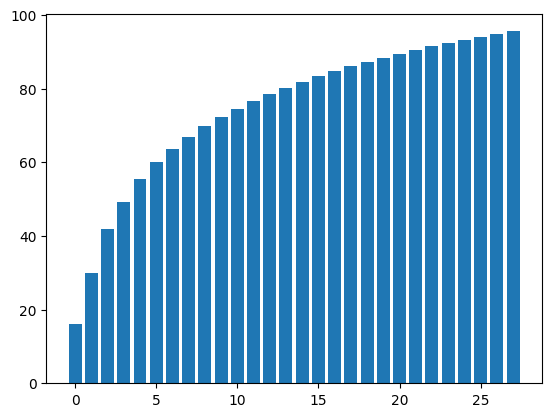

In [18]:
# Finding out how many features are required to explain the variance of the data

total = sum(pca.explained_variance_)
k = 0
current_variance = 0
while current_variance/total < 0.95:
    current_variance += pca.explained_variance_[k]
    k = k + 1

print(k, " features explain around 95% of the variance. From 7129 features to ", k, ", not too bad.", sep='')

pca = PCA(n_components=k)
x_train.pca = pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

var_exp = pca.explained_variance_ratio_.cumsum()
var_exp = var_exp*100
plt.bar(range(k), var_exp);

**INFERENCE:**\
Even though we have narrowed down from 7k+ to 28 features, we cannot plot and interpret data in the 28th dimension. So we need to narrow down to the top 3 features.

In [19]:
# Plotting the 3 most varying components to see what PCA does to the features

pca3 = PCA(n_components=3).fit(x_train)
x_train_reduced = pca3.transform(x_train)

plt.clf()
fig = plt.figure(1, figsize=(10,6 ))
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(x_train_reduced[:, 0], x_train_reduced[:, 1], x_train_reduced[:, 2], c = y_train.iloc[:,1], cmap = plt.cm.Paired, linewidths=10)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.zaxis.set_ticklabels([])
plt.show()

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, '2D Transformation of the Above Graph')

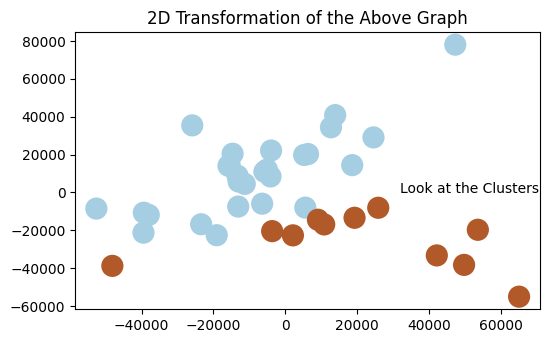

In [20]:
# Converting the 3D graph to 2D

fig = plt.figure(1, figsize = (6, 3.6))
plt.scatter(x_train_reduced[:, 0],  x_train_reduced[:, 1], c = y_train.iloc[:,1], cmap = plt.cm.Paired, linewidths=10)
plt.annotate('Look at the Clusters', xy = (32000,0))
plt.title("2D Transformation of the Above Graph")

# **Model Building**

In [21]:
# Baseline

acc = round(1 - np.mean(y_test.iloc[:,1]), 3)
print(f"Simply predicting everything as Acute Lymphoblastic Leukemia (ALL) results in an accuracy of: {acc*100}%")

Simply predicting everything as Acute Lymphoblastic Leukemia (ALL) results in an accuracy of: 58.8%


K-means accuracy: 76.5%


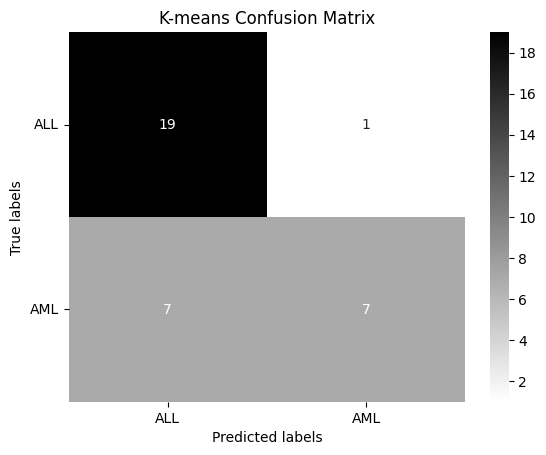

In [22]:
# K-Means Clustering

kmeans = KMeans(n_clusters=2, random_state=0).fit(x_train_scl)
km_pred = kmeans.predict(x_test_scl)
acc = round(accuracy_score(y_test.iloc[:,1], km_pred), 3)
print(f'K-means accuracy: {acc*100}%')
cm_km = confusion_matrix(y_test.iloc[:,1], km_pred)
ax = plt.subplot()
sns.heatmap(cm_km, annot=True, ax = ax, fmt='g', cmap='binary')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('K-means Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360)
plt.show()

K-MEANS had 8 misclasifications.

---

Naive Bayes accuracy: 91.2%


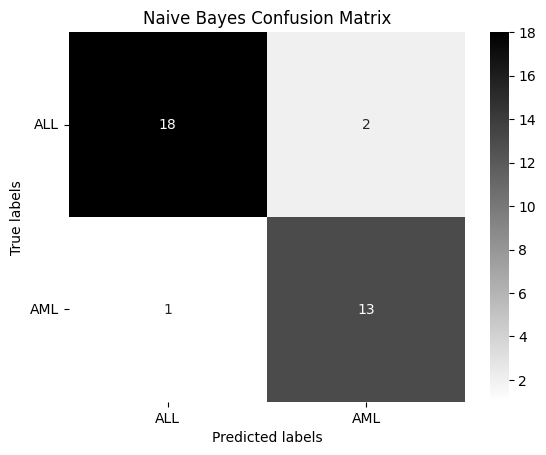

In [23]:
# Naive Bayes

nb_model = GaussianNB()
nb_model.fit(x_train, y_train.iloc[:,1])
nb_pred = nb_model.predict(x_test)
acc = round(accuracy_score(y_test.iloc[:,1], nb_pred), 3)
print(f'Naive Bayes accuracy: {acc*100}%' )
cm_nb =  confusion_matrix(y_test.iloc[:,1], nb_pred)
ax = plt.subplot()
sns.heatmap(cm_nb, annot=True, ax = ax, fmt='g', cmap='binary')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Naive Bayes Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360)
plt.show()

Naive Bayes had 3 misclasifications.

---

Best Parameters:
 {'C': 1, 'penalty': 'l1'}
Logistic Regression accuracy: 100.0%


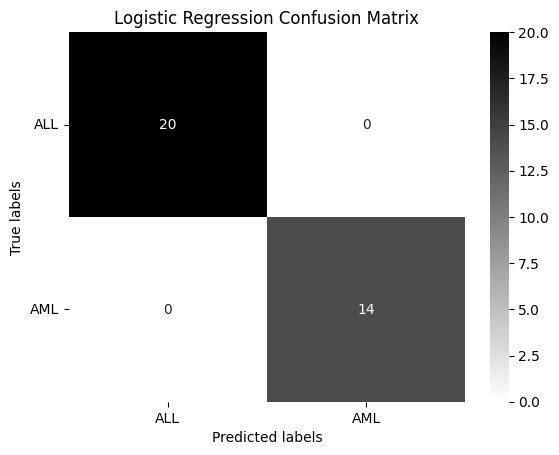

In [24]:
# Logistic Regression (using grid search cross-validation)

log_grid = {'C': [1e-03, 1e-2, 1e-1, 1, 10], 'penalty': ['l1', 'l2']}
log_estimator = LogisticRegression(solver='liblinear')
log_model = GridSearchCV(estimator=log_estimator, param_grid=log_grid, cv=3, scoring='accuracy')
log_model.fit(x_train, y_train.iloc[:,1])
print("Best Parameters:\n", log_model.best_params_)
best_log = log_model.best_estimator_
log_pred = best_log.predict(x_test)
acc = round(accuracy_score(y_test.iloc[:,1], log_pred), 3)
print(f'Logistic Regression accuracy: {acc*100}%')
cm_log =  confusion_matrix(y_test.iloc[:,1], log_pred)
ax = plt.subplot()
sns.heatmap(cm_log, annot=True, ax = ax, fmt='g', cmap='binary')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Logistic Regression Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360)
plt.show()

Using normal strength of regularisation (C=1) and penalizing the sum of absolute values of the weights (penalty=L1), we get 0 misclassifications. AMAZING!

---

Best Parameters:
 {'C': 0.1, 'decision_function_shape': 'ovo', 'gamma': 1, 'kernel': 'linear'}
SVM accuracy: 97.1%


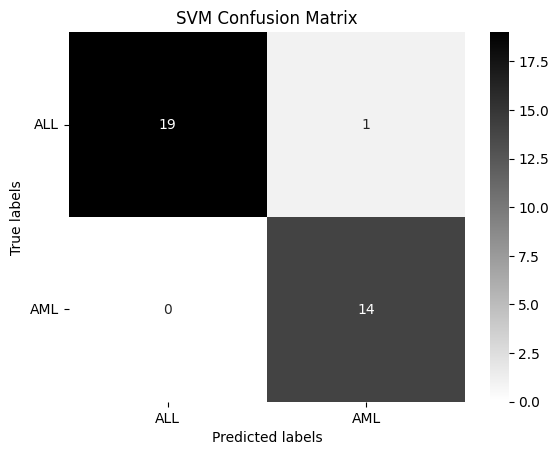

In [25]:
# Support Vector Machine

svm_param_grid = {'C':[0.1, 1, 10, 100], 'gamma':[1, 0.1, 0.01, 0.001, 0.00001, 10], "kernel":["linear", "rbf", "poly"], "decision_function_shape":["ovo", "ovr"]}
svm_grid = GridSearchCV(SVC(), svm_param_grid, cv=3)
svm_grid.fit(x_train_pca, y_train.iloc[:,1])
print("Best Parameters:\n", svm_grid.best_params_)
best_svc = svm_grid.best_estimator_
svm_pred = best_svc.predict(x_test_pca)
acc = round(accuracy_score(y_test.iloc[:,1], svm_pred), 3)
print(f'SVM accuracy: {acc*100}%',)
cm_svm =  confusion_matrix(y_test.iloc[:,1], svm_pred)
ax = plt.subplot()
sns.heatmap(cm_svm, annot=True, ax = ax, fmt='g', cmap='binary')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('SVM Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360)
plt.show()

Only 1 wrongly classified by our SVM. This a very good model as well.

---

Best Parameters:
 {'bootstrap': False, 'max_features': 0.6, 'min_samples_leaf': 8, 'min_samples_split': 3, 'n_estimators': 60}
Random Forest accuracy: 97.1%


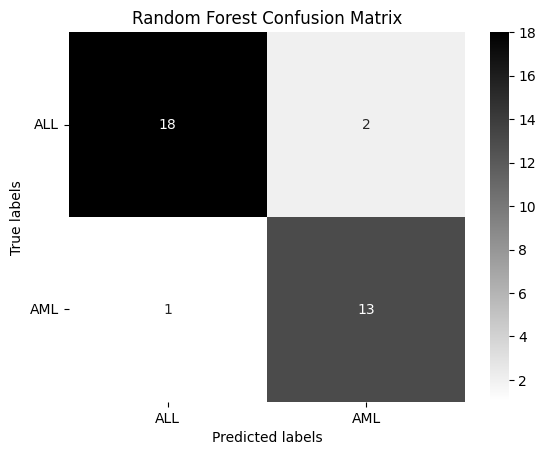

In [26]:
# Random Forest

rf_param_grid = {'bootstrap': [False, True],
         'n_estimators': [60, 100],
         'max_features': [0.6, 1.0],
         'min_samples_leaf': [8, 14],
         'min_samples_split': [3, 7]
        }
rf_estimator = RandomForestClassifier(random_state=0)
rf_model = GridSearchCV(estimator=rf_estimator, param_grid=rf_param_grid, cv=3, scoring='accuracy')
rf_model.fit(x_train, y_train.iloc[:,1])
print("Best Parameters:\n", rf_model.best_params_)
rf_model_best = rf_model.best_estimator_
rf_pred = rf_model_best.predict(x_test)
ans = round(accuracy_score(y_test.iloc[:,1], rf_pred), 3)
print(f'Random Forest accuracy: {acc*100}%')
cm_rf = confusion_matrix(y_test.iloc[:,1], rf_pred)
ax = plt.subplot()
sns.heatmap(cm_rf, annot=True, ax = ax, fmt='g', cmap='binary')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Random Forest Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360)
plt.show()

Random Forest has 3 misclassifications.

---

XGB (no PCA or Grid Search) accuracy: 91.2%


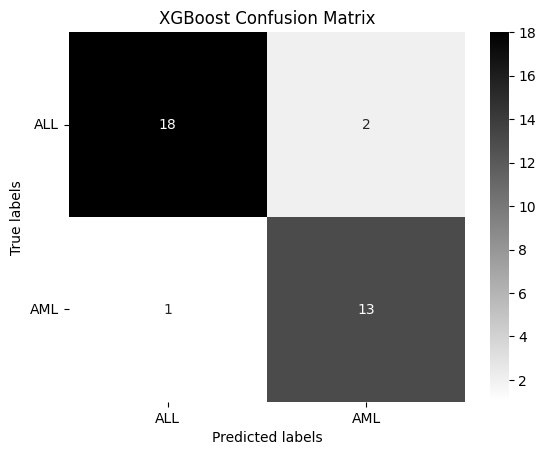

In [27]:
# XGBoost without PCA or Grid Search to avoid overfitting

xgb3_model = xgb.XGBClassifier()
xgb3_model.fit(x_train, y_train.iloc[:,1])
xgb3_pred = xgb3_model.predict(x_test)
acc = round(accuracy_score(y_test.iloc[:,1], xgb3_pred), 3)
print(f'XGB (no PCA or Grid Search) accuracy: {acc*100}%')
cm_xgb3 = confusion_matrix(y_test.iloc[:,1], xgb3_pred)
ax = plt.subplot()
sns.heatmap(cm_xgb3, annot=True, ax = ax, fmt='g', cmap='binary')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('XGBoost Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360)
plt.show()

Similar performance as Random Forest, 3 misclassifications for XGBoost.

---

Epoch 1/50
8/8 [==============================] - 1s 27ms/step - loss: 0.6882 - accuracy: 0.8000 - val_loss: 0.6064 - val_accuracy: 0.6250
Epoch 2/50
8/8 [==============================] - 0s 5ms/step - loss: 0.6536 - accuracy: 0.9333 - val_loss: 0.5075 - val_accuracy: 0.7500
Epoch 3/50
8/8 [==============================] - 0s 7ms/step - loss: 0.6142 - accuracy: 0.9667 - val_loss: 0.4519 - val_accuracy: 0.8750
Epoch 4/50
8/8 [==============================] - 0s 5ms/step - loss: 0.5691 - accuracy: 0.9667 - val_loss: 0.4164 - val_accuracy: 0.7500
Epoch 5/50
8/8 [==============================] - 0s 5ms/step - loss: 0.5157 - accuracy: 0.9667 - val_loss: 0.4000 - val_accuracy: 0.7500
Epoch 6/50
8/8 [==============================] - 0s 5ms/step - loss: 0.4644 - accuracy: 0.9667 - val_loss: 0.3873 - val_accuracy: 0.7500
Epoch 7/50
8/8 [==============================] - 0s 4ms/step - loss: 0.4036 - accuracy: 0.9667 - val_loss: 0.3847 - val_accuracy: 0.7500
Epoch 8/50
8/8 [=================

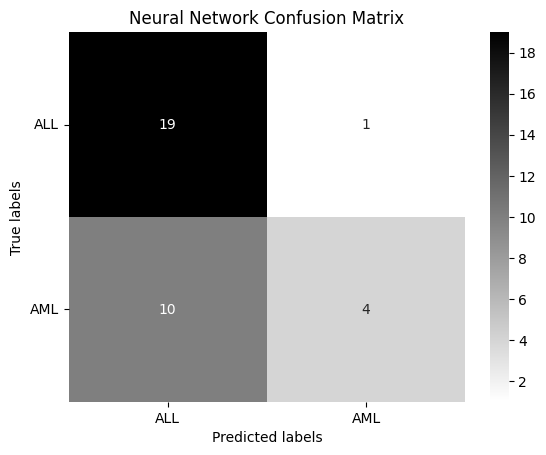

In [28]:
# Neural Networks

partial_x_train = x_train_scl[:30]                              # Creating data for Neural Networks
x_val = x_train_scl[30:]
y_train_label = y_train.iloc[:,1]
partial_y_train = y_train_label[:30]
y_val = y_train_label[30:]

model = Sequential()                                            # Neural Network Model
model.add(Dense(16, activation='relu', input_shape=(7129,)))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', verbose=1, patience=3)
history = model.fit(partial_x_train, partial_y_train, epochs=50, batch_size=4, validation_data=(x_val, y_val), callbacks=[es])

nn_pred = model.predict(x_test_scl).round()                     # Results and confusion matrix
acc = round(accuracy_score(y_test.iloc[:,1], nn_pred), 3)
print(f'Neural Network accuracy: {acc*100}%')
cm_nn = confusion_matrix(y_test.iloc[:,1], nn_pred)
ax = plt.subplot()
sns.heatmap(cm_nn, annot=True, ax = ax, fmt='g', cmap='binary')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Neural Network Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360);
plt.show()

The neural network isn't as good as some of the other models and should be ignored.

---

# **CONCLUSION:**
Ranking as per accuracy, we get the results as:

|S. No.|Model|Accuracy|
|---|---|---|
|1.|Logistic Regression|100%
|2.|Suppor Vector Machine|97.1%|
|3.|XGBoost|91.2%|
|3.|Random Forest|91.2%|
|3.|Naive Bayes|91.2%|
|4.|K-means|76.5%|
|5.|Neural Network|67.6%|
|6.|Simple Guesses|58.8%|

\
Hence, *Logistic Regression* is the best choice for this Dataset.